# Deep Learning for Medical Point-of-Care: Using Neural Networks to Diagnose Skin Cancer

Author: "Mark R. Tyrrell"
Module: CSC8635 Machine Learning

## Introduction
The increased accuracy and agility of machine learning in recent years has pushed usability of the technology to the frontiers of many fields. This phenomenon is readily apparent in the field of medicine, where deep learning algorithms are being used for medical imaging analyses (Shen et al. 2017). The coincident emphasis on point-of-care testing (POCT) - replicating lab capacities at the clinical level - in the policy frameworks of many national health services further drives demand for these technologies. Applications of deep learning for POTC can improve patient outcomes by providing frontline clinicians with the tools necessary to make expert diagnoses without the need for specialist referrals. This in turn can decrease treatment lead-time, allowing for quicker intervention and better prognoses. 

This study examines the viability of developing and deploying a deep learning algorithm for a POCT application using publicly available data and commercial off-the-shelf (COTS) computing equipment. A convolutional neural network (CNN) will be used to analyse images of skin lesions in order to diagnosis the presence of skin cancer. The results will be compared with human expert assessment.

## Background

The prevalence of melanoma has increased steadily per capita since 1975 and continues to grow at 2.6 percent annually in the United States (Siegal et al. 2018; Higgens et al. 2014). Though low compared with other cancers, the mortality rate of melanoma is 8% in the United States (Siegal et al. 2018). This statistic highlights the relatively high survivability of this type of cancer, owing primarily to its visibility. In most cases malignant melanoma are identified early, and are subsequently curable. Conversely, treatment for metastasized melanoma is limited, resulting in a 5-year survival rate for stage-four melanoma of less than 15 percent (Higgens et al. 2014), underscoring the importance of early and accurate diagnoses. 

Malformed, mixed-pigmented and growing skin lesions are often readily apparent to patients and to primary healthcare providers while conducting physicals. Manual inspection of skin lesions using the Asymmetry, Border irregularity, Color variegation, Diameter >6 mm (ABCD) method for identifying potential malignancies has been the norm since 1985 and provides a first layer of screening with varying degrees of efficacy (Abbasi et al. 2004). If a malignancy is suspected, patients are referred to a determatologist for further screening. 

More advanced clinical-level diagnosis techniques such as dermatoscopy provide increased accuracy. However, this technology still requires the expertise of highly-trained specialists (Ebell 2008). Clearly there is a need to provide primary healthcare workers with easily applied, powerful diagnostic tools in order to identify malignant skin lesions prior to metastatic progression of the cancer. 

Computer vision is a logical candidate technology for automated skin cancer diagnosis. Deep learning algorithms have advanced steadily over the past two decades. CNNs can now match humans in simple object detection, and are being applied to many facets of medical imaging (Shen et al. 2017). The development of algorithms to detect melanomas and other skin cancers has been facilated by the recent release of the HAM10000 dataset (Tschandl et al. 2018). At the same time, open source machine learning libraries, cloud computing and smartphone cameras have made the training and deployment of CNNs accessible. Combined, these technologies and resources can be used to produce a cheap and accurate tool for diagnosing malignant skin lesions. This paper will demonstrate the simple development and deployment of a prototype diagnostic tool as proof-of-concept.  

## Methodology
In keeping with the goal of producing an affordable tool for diagnosing skin cancer, this project made exclusive use of open source toolkits. All data processing was accomplished using Python. The development of the CNN used the Python Keras library exclusively. Keras is a wrapper API on the Tensorflow library, and allows quick deployment of deep learning models with a user friendly syntax. 

Training of the CNN was conducted using ad hoc cloud computing resources. Microsoft Azure provides an array of different services including virtual machines (VMs) exclusively designed for machine learning tasks. This project utitlised an Azure NC6 Deep Learning VM with 6 virtual CPUs, 56 GB memory and a dedicated NVIDIA GPU. The total online time for the VM including setup time, code debugging and parameter optimisation was approximately 20 hours. The cost for this cloud-based resource was less than £20, make it highly applicable for this project.


#### Data Understanding
The HAM10000 dataset primarily consists of 10015 medium resolution images of seven different types of skin lesions, comprising 95 percent of lesions encountered in standard clinical practice (Tschandl et al. 2018). The images are preprocessed to ensure a minimal standard of contrast, focus and magnification of the lesion. The ground truth for each image is contained in an accompanying csv file along with metadata including the age and sex of the subject, the location of the lesion on the body, and the diagnosis method.

The patient descriptor variables included in the metadata file such as age and sex could be used to contribute to the model. Age in particular has a direct positive correlation with increased prevalence of melanoma (Siegal et al. 2018). These correlations are well known to health care professionals and form the basis of screening regimes. As this project focuses on the use of innovative uses of image analysis for diagnoses, the model will exclude the metadata variables and only utilise the skin lesion images for model building.

Table displays the quantity of each type of skin lesion represented in the dataset. While the dataset in total contains a reasonable quantity of data for training, the data are highly imbalanced. Melanoma comprises the majority of the samples (67%). This is problematic and can detrimentally affect classification performance (Buda et al. 2018). As the prior probability of any of the samples being Melanoma is very high at 67 percent, the model accuracy will be biased toward selecting Melanoma. The effect is clearly evidenced by observing the training process. The accuracy performance of the first epoch is no less than 66 percent in most trials. Additionally, the size of the dataset in this case further compounds the problem. The remaining 3310 samples are divided amongst the minority categories. Some categories contain less than 200 samples. This is insufficient for training a reliable classifier. 


**Table 1: HAM10000 Image data quantity by ground truth category**

| Diagnostic Category | n |
|:------|:-----:|
|   Actinic Keratoses  | 327|
|   Basal Cell Carcinoma  | 514|
|   Benign Keratosis  | 1099|
|   Dermatofibroma  | 115|
|   Melanocytic Nevi  | 1113|
|   Melanoma  | 6705|
|   Vascular  | 142 |


The imbalance in the dataset can be adjusted by dropping overrepresented samples, artificially increasing underrepresented samples, or a combination of both. Due to the relatively small size of the dataset, the only viable option in this case is oversampling the minority categories. The naive method for this involves creating duplicates of minority samples, ideally resulting in an even distribution of the categories. Further methods involve interpolation between samples of the same category to create new samples, for instance synthetic minority oversampling technique (SMOTE). 

Transfer learning provides yet another avenue for tackling the issues with the dataset. This is accomplished by using the convolutional and pooling layers of a CNN trained on another dataset, then adapting the fully connected layers to the target dataset and retraining. This technique is widely used and has proven to be effective in challenging contexts (Ramcharan et al. 2017). However, due to the excessive implementation requirements of these methods, both transfer learning and oversampling are beyond the scope of this study. 

Batch normalisation was tried on the first layer to mitigate the issues caused by imbalance. This method attempts to provide a normally distributed sample of the dataset to the input batch for each epoch. The algorithm can improve overall performance of CNNs as well as exhibit regularisation effects (Ioffe and Szegedy 2015). Surprisingly the model did not perform as well with batch normalisation enabled, and it was therefore removed from the final model.

#### Data Preparation
The preparation of the data involves identifying the jpeg file paths from multiple folder locations, then merging the file paths vector with the metadata file. These file paths are then used to source the files, resizing and converting them to numpy arrays and inserting them into a new column in the metadata file. 

In [2]:
# Assign project template directory
data_dir = "/Users/MT/Desktop/DS_Projects/CSC8635_ML_Project"

In [3]:
# Load standard data processing libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Import metadata df
meta = pd.read_csv(os.path.join(data_dir,"data","HAM10000_metadata.csv"))
# Iterate through data_dir looking for jpg files and append to images_ls
images_ls = []
for dir,_,_ in os.walk(data_dir):
    images_ls.extend(glob(os.path.join(dir,"*.jpg"))) 

# Convert images_ls to dataframe and assign variable name
images_df = pd.DataFrame(images_ls)
images_df.columns = ['path']

# Extract image id from path for join with meta df
images_df['image_id'] = images_df['path'].str[-16:-4]

# Join image_df with meta on image id
meta = pd.merge(meta, images_df, how='left', on=['image_id'])

Using TensorFlow backend.


The image data is provided in 600x450 pixel jpeg files. As higher-resolution imaging requires exponentially higher processing capability, the images were first resized to 100x75, maintaining the original aspect ratio. The resize operation requires considerable processing time, and therefore the output dataframe is cached as a *pickle* file to allow quick reloading. 

In [4]:
# Iterate through images, resizing down to to 100x75 pixels, converting to array and inserting into new column
#meta['image'] = meta['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# Cache result
#meta.to_pickle(os.path.join(data_dir,"cache/meta_cache.p"))

# Import cached metadata df (uncomment to implement)
meta = pd.read_pickle(os.path.join(data_dir,"cache","meta_cache.p"))

Next the response and predictor variables are independently separated from the **meta** dataframe as vectors. The response vector **Y** contains the 7 skin lesion categories in string form. These categories are converted to integers, then into categories using *one-hot encoding*. 

The **X** vector contains the arrays of resized images of skin lesions. The array values are converted to floats, then centered by subtracting the mean of the vector, and normalised by dividing by the standard deviation of the vector.

The vectors are then split twice using the **sklearn** *train-test-split* function. The first split separates allocates 10 percent of the data for post-training evaluation. The second split allocates 10 percent of the data for training cross-validation. A random seed is set for each split 

In [5]:
# Extract predictor variable (images) and labels as seperate vectors
X=meta['image']
Y=meta['dx']

# Integer encode each response category and then one-hot encode
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = to_categorical(Y, num_classes = 7)

# Iterate through images vector and normalise image array (divide by max RGB value = 255)
X = np.asarray(meta['image'].tolist())
X = X.astype('float32')
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

# Split test/train set for predictor and label variables
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=10)

# Split training set further for cross validation (NOT used for talos optimisation)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 10) 

#### Data Modeling
The CNN was constructed using the Keras API for Tensorflow. The Keras package is optimised for GPU operation, providing relatively quick training time when implemented on a GPU-enabled machine. Hyper-parameter optimisation was accomplished using the Talos library.

In [6]:
# Import keras utilities
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

The final model consisted of 2 separate sets of 2 convolutional layers with 32 filter layers each. Each set was followed by a pooling layer and set for differing dropout levels for regularisation. The hyper-parameter optimisation process resulted in RELU selected as the activation function for these layers. 

The resulting model is shown below.

In [7]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = X_train.shape[1:]
act = 'relu'
n_classes = 7

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation=act,padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation=act,padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation=act))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 75, 100, 3)        12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
__________

The ADAM algorithm was selected for step optimisation, with an initial learning rate of 0.0001 and standard beta settings. Loss was evaluated using cross entropy. In addition to loss minimisation, Accuracy was used as the measure of model performance. ROC AUC has been shown to be a better measure in cases of imbalanced data, as it measures the ration of false postives to false negatives (Buda et al. 2018). However, there is no simple implementation in Keras.

Automated learning rate reduction was also enabled using the Keras *ReduceLROnPlateau* callback function. This allowed the model to make adjustments to the learning rate during training when minimal change occured in the loss function over successive epochs. 

Additionally Keras allows the ability to make up for smaller dataset sizes by augmenting the input dataset. For instance, this function can rotate, zoom, shift or flip images. This allows for greater model generalisation to new data. 

In [8]:
# Define the optimizer
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# or 5 e-4

# Start with no LR decay. Then optimise in subsequent models
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# With data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

Prior to model fitting, a random seed was set in order to ensure reproducibility. 

In [12]:
# Set random seed to ensure reproducability
np.random.seed(10)      

# Fit the model
epochs = 100 
batch_size = 9
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Selection of the hyper-parameters involved the use of Talos. This function allows automated training of models using different combinations of hyper-parameters. Due to the many permutations resulting from feeding just a few hyper-parameter ranges and the associated training time for each model, this tool must be used with caution. In practice, the utility works well following initial rough manual selection of learning rate, epochs and batch sizes.

In [ ]:
# import talos
import talos as ta

# Define model inside function to be called by ta.Scan
def rand_search(X_train, Y_train, X_val, Y_val, params):
    conv_dropout = float(params['conv_dropout'])
    dense1_neuron = int(params['dense1_neuron'])
    
    model = Sequential()
#    model.add(BatchNormalization(input_shape=X_train.shape[1:]))
    model.add(Conv2D(32, (3, 3), padding='same', activation=params['activation']))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(conv_dropout))

    model.add(BatchNormalization(input_shape=X_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), padding='same', activation=params['activation']))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(conv_dropout))

    # Extra layers used during random search
#    model.add(BatchNormalization(input_shape=X_train.shape[1:]))
#    model.add(Conv2D(256, (5, 5), padding='same', activation=params['activation']))
#    model.add(MaxPool2D(pool_size = (2, 2)))
#    model.add(Dropout(conv_dropout))

    model.add(Flatten())
    model.add(Dense(dense1_neuron, activation=params['activation']))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Fit model
    out = model.fit(
        x, y, epochs=50, 
        batch_size=10, 
        verbose=1,
        validation_data=[x_val, y_val],
        callbacks=[learning_rate_reduction]
    )
    return out, model

# Set ranges for hyper-parameter optimisation
para = {
    'dense1_neuron': [128, 256],
    'activation': ['relu', 'elu'],
    'conv_dropout': [0.2, 0.4, 0.5]
}

# Start scan using input data (validation sets created automatically)
scan_results = ta.Scan(X_train, Y_train, para, rand_search)

In [ ]:
# Load InceptionV3 model from keras and associated modules
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50 
batch_size = 15
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
# Save model
model.save(os.path.join(data_dir,"tests","cnn.hdf5"))

# Convert model training history dictionary to dataframe for plotting
hist_df = pd.DataFrame(history.history['acc'])
hist_df.columns = ['train_acc']
hist_df['train_loss'] = pd.DataFrame(history.history['loss'])
hist_df['val_acc'] = pd.DataFrame(history.history['val_acc'])
hist_df['val_loss'] = pd.DataFrame(history.history['val_loss'])
hist_df['lr'] = pd.DataFrame(history.history['lr'])
hist_df['epoch'] = epochs

# Cache history df
hist_df.to_pickle(os.path.join(data_dir,"cache","hist_df_1822-05.p"))

## Results
Following training of the model using  The results show that even this simple implementation of a CNN can be an effect diagnostic tool for skin cancer. 

The model 




How successful has it been? Provide evidence, using appropriate evaluation methodologies, and comment on the strengths/weaknesses of your evidence in answering this question.

In [9]:
# Load cached model
from keras.models import load_model
model = load_model(os.path.join(data_dir,"tests","cnn_1822-05_78.1TEST_82TR.hdf5"))

# Load cached metadata df
hist_df = pd.read_pickle(os.path.join(data_dir,"cache","hist_df_1822-05.p"))

In [ ]:
results_df = pd.DataFrame(['Loss','Accuracy'])
results_df.columns = ['Metric']
results_df['Training'] = pd.DataFrame(model.evaluate(X_test, Y_test, verbose=0))
results_df['Validation'] = pd.DataFrame(model.evaluate(X_val, Y_val, verbose=0))
# Cache results df
results_df.to_pickle(os.path.join(data_dir,"cache","results_df_1822-05.p"))

In [44]:
# Load cached metadata df
results_df = pd.read_pickle(os.path.join(data_dir,"cache","results_df_1822-05.p"))
results_df

Metric  Training  Validation
0      Loss  0.618488    0.612541
1  Accuracy  0.781437    0.787140

In [45]:
# Make sliced copies of hist_df for plotting
hist_df_acc = hist_df.drop({'train_loss','val_loss','lr'}, axis=1)
hist_df_loss = hist_df.drop({'train_acc','val_acc','lr'}, axis=1)

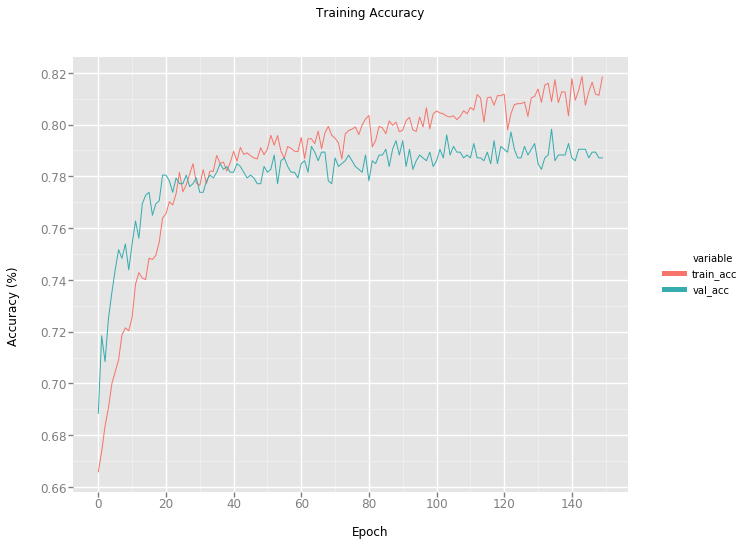

<ggplot: (-9223372029732941308)>

In [46]:
from ggplot import *

# Plot Training Accuracy
ggplot(pd.melt(hist_df_acc, id_vars=['epoch']), aes(x='epoch', y='value', color='variable')) +\
    geom_line() +\
    xlab("Epoch") + ylab("Accuracy (%)") + ggtitle("Training Accuracy")

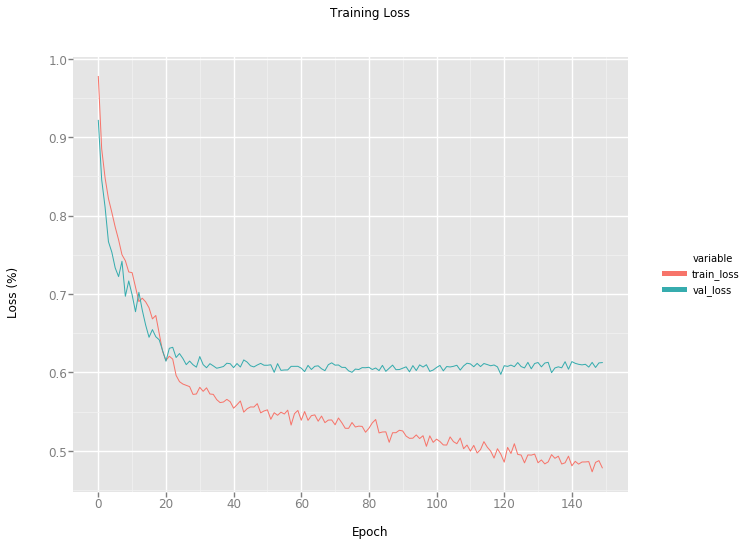

<ggplot: (7121861433)>

In [47]:
# Plot Training Loss
ggplot(pd.melt(hist_df_loss, id_vars=['epoch']), aes(x='epoch', y='value', color='variable')) +\
    geom_line() +\
    xlab("Epoch") + ylab("Loss (%)") + ggtitle("Training Loss")

In [53]:
y_score = model.predict(X_test)

# Cache y_score
np.save(os.path.join(data_dir,"cache","y_score_1822-05.npy"), y_score)

In [48]:
# Load cached y_score
y_score = np.load(os.path.join(data_dir,"cache","y_score_1822-05.npy"))

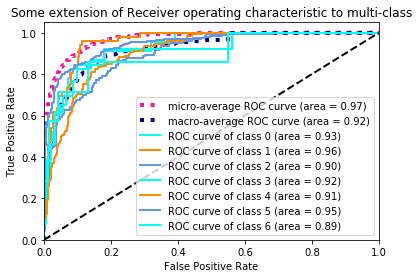

In [49]:
##### ROC AUC Plot
# Source: https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Discussion

What are the future implications for work in this area? If appli- cable, which areas of extension work are now possible due to the foundational work you have performed in this project?

## Conclusion

A brief reflection on your personal and professional learning in undertaking this project. Here you can comment on how you found the process, what you learned about the technologies and methodologies you used, which aspects you found most diffi- cult/straightforward, and any conclusions which will inform the way you undertake similar projects in the future.

## References


Shen et al. 2017
@article{doi:10.1146/annurev-bioeng-071516-044442,
author = {Shen, Dinggang and Wu, Guorong and Suk, Heung-Il},
title = {Deep Learning in Medical Image Analysis},
journal = {Annual Review of Biomedical Engineering},
volume = {19},
number = {1},
pages = {221-248},
year = {2017},
doi = {10.1146/annurev-bioeng-071516-044442},
    note ={PMID: 28301734},
    
    
    
    
Higgens et al. 2014
Point of care cutaneous imaging technology in melanoma screening and mole mapping
H. William Higgins II, Kachiu C. Lee, David J. Leffell
F1000Prime Rep. 2014; 6: 34. Published online 2014 May 6. doi: 10.12703/P6-34


Siegal et al. 2018
Cancer statistics, 2018

Abbasi et al. 2004
Early Diagnosis of Cutaneous Melanoma
Revisiting the ABCD Criteria
Naheed R. Abbasi, MPH, MD; Helen M. Shaw, PhD; Darrell S. Rigel, MD; et al

Ebell 2008
Clinical Diagnosis of Melanoma
MARK EBELL, MD, MS, University of Georgia, Athens, Georgia
Am Fam Physician. 2008 Nov 15;78(10):1205-1208.

Tschandl et al. 2018
Data Descriptor: The HAM10000 dataset, a large collection of multi-source dermatoscopic images
of common pigmented skin lesions
Philipp Tschandl1, Cliff Rosendahl2 & Harald Kittler1


@misc{chollet2015keras,
  title={Keras},
  author={Chollet, Fran\c{c}ois and others},
  year={2015},
  howpublished={\url{https://keras.io}},
}

Buda et al. 2018
Mateusz Buda, Atsuto Maki, and Maciej A Mazurowski. A systematic study of the class imbalance problem in convolutional neural networks. Neural Networks, 106:249–259, 2018.

Ramcharan et al. 2017
Amanda RamcharanKelsee BaranowskiKelsee BaranowskiPeter Charles McCloskeyPeter Charles McCloskeyShow all 6 authorsDavid P. Hughes
Using Transfer Learning for Image-Based Cassava Disease Detection
June 2017Frontiers in Plant Science 8

Ioffe and Szegedy 2015
Sergey Ioffe, Christian Szegedy
Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift